In [2]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as a3d
%matplotlib inline

In [45]:
xbeam = np.loadtxt('./outputs/xbeam.csv', dtype=np.float32).reshape((-1, 3, 3))
ybeam = np.loadtxt('./outputs/ybeam.csv', dtype=np.float32).reshape((-1, 3, 3))

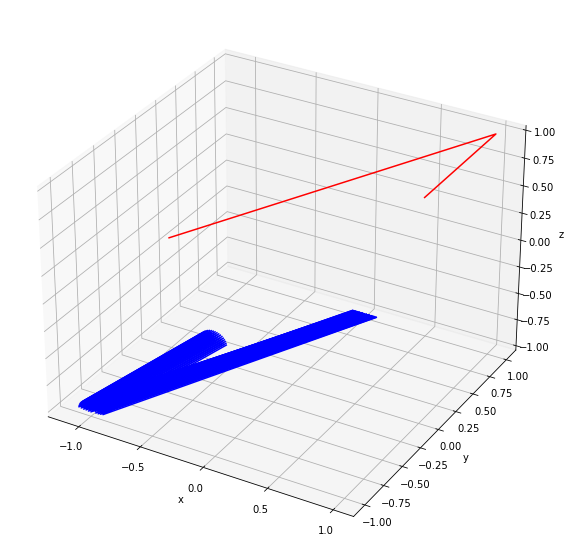

In [50]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.plot(xbeam[0, 0, :], xbeam[0, 1, :], xbeam[0, 2, :], 'r')

for r in range(ybeam.shape[0]):
  ax.plot(ybeam[r, 0, :], ybeam[r, 1, :], ybeam[r, 2, :], 'b')
  # ax.plot(ybeam[r, :, 0], ybeam[r, :, 1], ybeam[r, :, 2], 'm')


In [8]:
b_norms = np.asarray(
  [[-1.0, 0.0, 0.0], [0.0, -1.0, 0.0],  [-0.347252784,  -0.782219564,	0.517250479],
  [0.393457551, 0.541547875,	0.742911202], [0.636627669,0.206852872,	-0.742911233], 
  [0.347252811,0.782219525,	-0.517250519], [0.851239679,-0.502239228,	0.152140616],
  [0.740705521,-0.654376459,	-0.152140661], [0.347250266,-0.112828417,	0.930960257],
  [0.214610424,0.96477748,	-0.152140661], [0.214612459,-0.295388659,	-0.930960274],
  [0.740710551,0.428718814,	0.517250479], [0.74071057,-0.428718733,	-0.517250519],
  [0.214612457,0.295388714,	0.930960257], [0.636627941,0.571976193,	-0.517250519],
  [0.393458463,0.90666624,	0.152140616], [-8.47266E-09,0.365120484,	-0.930960274],
  [4.65998E-08,-0.66938998,	0.742911202], [0.851239626,0.502239303,	-0.152140661],
  [0.636628012,-0.57197615,	0.517250479], [0.347250215,	0.112828436,	-0.930960274],
  [0.636627721,	-0.206852824,	0.742911202], [0.740705466,	0.654376532,	0.152140616],
  [0.347252893,	-0.782219515,	0.517250479], [0.393458544,	-0.906666197,	-0.152140661],
  [0.983876179,	0.094025976,	-0.152140661], [0.214610515,	-0.964777466,	0.152140616],
  [0.983876194,	-0.094025886,	0.152140616], [0.178843722,	-0.836938961,	-0.517250519],
  [0.851242003,	-0.088537859,	-0.517250519], [0.851242019,	0.08853794,	0.517250479],
  [-0.983876181,	-0.094026023,	0.152140616], [-0.214610381,	-0.964777496,	0.152140616],
  [-0.983876183,	0.094025931,	-0.152140661], [-0.178843606,	-0.836938985,	-0.517250519],
  [-0.851241991,	-0.088537977,	-0.517250519], [-0.34725022,	0.11282842,	-0.930960274],
  [2.5418E-08,	-0.365120527,	0.930960257], [-0.740705496,	0.654376498,	0.152140616],
  [-0.393458418,	-0.906666252,	-0.152140661], [-1.55333E-08,	0.669389946,	-0.742911233],
  [-0.740710511,	-0.428718836,	-0.517250519], [-0.636627932,	-0.571976239,	0.517250479],
  [-0.85123965,	0.502239263,	-0.152140661], [-0.393457505,	-0.541547866,	-0.742911233],
  [-0.636627692,	-0.206852912,	0.742911202], [-0.214612471,	0.295388704,	0.930960257],
  [-0.636627968,	0.571976163,	-0.517250519], [-0.740710571,	0.428718779,	0.517250479],
  [-0.393458505,	0.906666222,	0.152140616], [-0.851239609,	-0.502239346,	0.152140616],
  [-0.34725025,	-0.112828466,	0.930960257], [-0.636627678,	0.206852842,	-0.742911233],
  [-0.74070543,	-0.654376562,	-0.152140661], [-0.214612418,	-0.295388689,	-0.930960274],
  [-0.851242023,	0.088537901,	0.517250479], [-0.178843689,	0.836938992,	0.517250479],
  [-0.214610469,	0.96477747,	-0.152140661], [-0.393457576,	0.541547857,	0.742911202],
  [-0.347252847,	0.782219509,	-0.517250519]],
  dtype=np.float32
)

np.savetxt('./beamnorms.csv', b_norms, fmt='%.9f')


## Creating Beam rays in circle

Using equation for polygon

$$
  R = \frac{a}{2 \sin(\frac{\pi}{n_0})}
$$

Where $R$ is radius of vertices (outer radius), $a$ is radius of edges between vertices (apothem, inner radius).

$n_0$ is the number of rays in the first ring. Choosing $n_0 = 8.32$ results in a total number of rays of 128, which is ideal for CUDA. 

$$
\begin{align*}
  N &= 128; &n_0 = 8.32 \\
  N &= 256; &n_0 = 17.00 \\
  N &= 512; &n_0 = 34.07 \\
  N &= 1024; &n_0 = 68.15
\end{align*}
$$

To find the number of rays per ring,

$$
  n = \frac{\pi}{\arcsin\left(\frac{\sin(\pi / n_0)}{i}\right)}
$$

In [ ]:
# Radius of Omega Chamber
bigR = 1
# Radius of beams
R = 0.1
# Number of concentric rings
m = 5
# Radius of inner ring
dR = R / m
# Polygon apothem (inner radius)
# a0 = np.sin(np.pi / 8.32)
a0 = np.sin(np.pi / 8.32)

rays = []
for b in b_norms:
    # Beam Origin
    xb, yb, zb = bigR * b 

    # If z-component is not zero, compute basis vector
    # otherwise use z-hat
    if b[2] != 0:
        e1 = np.asarray([0, dR, -dR * (b[1] / b[2])])
    else:
        e1 = np.asarray([0, 0, 1])

    # Normalize and compute remaining basis vector
    e1 = e1 / np.linalg.norm(e1)
    e2 = np.cross(e1, b)
    e2 = e2 / np.linalg.norm(e2)

    # Ray at center of beam
    rays.append([bigR * b, [0.0, 0.0, 0.0], -bigR * b])
    for i in range(1, m + 1):
        r = i * dR
        # calculate number of rays in ring i
        n = np.rint(np.pi / np.arcsin(a0 / i)).astype(int)

        for j in range(n):
            # angular offset
            theta = j * (2 * np.pi) / n
            # Calculate rotation around beam normal
            ray_center = (r * np.cos(theta) * e1) + (r * np.sin(theta) * e2)
            ray_origin = ray_center + bigR * b        
            ray_end = ray_center - bigR * b

            rays.append([ray_origin, ray_center, ray_end])

rays = np.asarray(rays)
print(rays.shape)


In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

for r in rays:
  ax.plot(r[:, 0], r[:, 1], r[:, 2])